In [1]:
import Pkg;
Pkg.activate(@__DIR__);
Pkg.instantiate();

  Activating environment at `~/tinympc-dev-julia/quadrotor_socp/Project.toml`


Precompiling 

project...


  ✓ TranscodingStreams


  ✓ Format


  ✓ CodecZlib


  ✓ OpenSSL


  ✓ Latexify


  ✓ HTTP


  ✓ UnitfulLatexify


  ✓ GR


  ✓ Plots


  9 dependencies successfully precompiled in 53 seconds (146 already precompiled)


In [2]:
using LinearAlgebra
using PyPlot
using Printf
using Random

In [3]:
include("../LibTinyMPC_clean.jl")

reset_solver! (generic function with 1 method)

In [140]:
# Quadrotor
NSTATES = 6
NINPUTS = 3
NHORIZON = 30
NTOTAL = 101

# Initialize cache, settings, bounds, socs, workspace, solver

###### Cache
rho = 1e1
Kinf = zeros(NINPUTS,NSTATES)
Pinf = zeros(NSTATES,NSTATES)
Quu_inv = zeros(NINPUTS,NINPUTS)
AmBKt = zeros(NSTATES,NSTATES)
APf = zeros(NSTATES)
BPf = zeros(NINPUTS)
my_cache = TinyCache(rho, Kinf, Pinf, Quu_inv, AmBKt, APf, BPf)
#####

##### Settings
abs_pri_tol = 1e-2
abs_dua_tol = 1e-2
max_iter = 50
check_termination = 1
en_state_bound = 0 # ENABLE CONSTRAINTS OR NOT
en_input_bound = 1
en_state_soc = 0
en_input_soc = 0
my_stgs = TinySettings(abs_pri_tol, abs_dua_tol, max_iter, check_termination, en_state_bound, en_input_bound, en_state_soc, en_input_soc)
#####

###### Bounds
umin = repeat([-1; -1; 0.0], 1, NHORIZON-1)*10
umax = repeat([1; 1; 2*g], 1, NHORIZON-1)*10
xmin = repeat([-1; -1; -1; -1; -1; -1], 1, NHORIZON)
xmax = repeat([1; 1; 1.0; 1; 1; 1], 1, NHORIZON)
z = zeros(NINPUTS, NHORIZON-1)
znew = zeros(NINPUTS, NHORIZON-1)
v = zeros(NSTATES, NHORIZON)
vnew = zeros(NSTATES, NHORIZON)
y = zeros(NINPUTS, NHORIZON-1)
g = zeros(NSTATES, NHORIZON)
my_bounds = TinyBounds(umin, umax, xmin, xmax, z, znew, v, vnew, y, g)
#####

##### SOCS (NOT USED IN THIS EXAMPLE)
ncu = 0
ncx = 0
cu = [0.3, 0]  # 0.3 is the thrust coefficient
cx = [0.6, 0]
qcu = [3, 0]  # 3 is the dimensions of 1st cone
qux = [3, 0]
Acu = [1, 0]
Acx = [1, 0]
zc = [zeros(NINPUTS, NHORIZON-1), zeros(NINPUTS, NHORIZON-1)]
vc = [zeros(NSTATES, NHORIZON), zeros(NSTATES, NHORIZON)]
zcnew = [zeros(NINPUTS, NHORIZON-1), zeros(NINPUTS, NHORIZON-1)]
vcnew = [zeros(NSTATES, NHORIZON), zeros(NSTATES, NHORIZON)]
yc = [zeros(NINPUTS, NHORIZON-1), zeros(NINPUTS, NHORIZON-1)]
gc = [zeros(NSTATES, NHORIZON), zeros(NSTATES, NHORIZON)]
my_socs = TinySocs(ncu, ncx, cu, cx, qcu, qux, Acu, Acx, zc, zcnew, vc, vcnew, yc, gc)
#####

##### Workspace
x = zeros(NSTATES, NHORIZON)
u = zeros(NINPUTS, NHORIZON-1)
q = zeros(NSTATES, NHORIZON)
r = zeros(NINPUTS, NHORIZON-1)
p = zeros(NSTATES, NHORIZON)
d = zeros(NINPUTS, NHORIZON-1)
pri_res_state = 1.0
pri_res_input = 1.0
dua_res_state = 1.0
dua_res_input = 1.0
status = 0
iter = 0
Q = 1e2*I(NSTATES) 
R = 1e0*I(NINPUTS)

#2D Double-integrator dynamics with gravity, similar to Rocket Landing
h = 0.05
gravity = 9.81
temp_n = Int(NSTATES/2)
Adyn = [I(temp_n) h*I(temp_n); zeros(temp_n,temp_n) I(temp_n)]
Bdyn = [0.5*h*h*I(temp_n); h*I(temp_n)] / 10; # thrust vectors = 1/10 controls, making condition number nicer :)
fdyn = [0.0, 0.0, -0.5*h*h*gravity, 0.0, 0.0, -h*gravity] * 1

t = h*(0:NTOTAL-1)
Xref = zeros(NSTATES, NTOTAL)
x0 = [0, 0, 1.0, 0, 0, 0.0]
x[:,1] = 1*x0
xg = [2.0, 0.0, 1.0, 0.0, 0.0, 0.0]

for k = 1:NTOTAL
  # Xref[1:3,k] = sin(1*t[k])*2*ones(temp_n)
  Xref[1:3,k] = (x0 + (k-1)*(xg-x0)/(NTOTAL-1))[1:3]
  # Xref[:,k] .= xg
end
Xref = hcat([Xref repeat(xg, 1, NHORIZON)])
x0 .= Xref[:,1]

Uref = repeat([0; 0; gravity*10], 1, NTOTAL-1) 

Xref_hrz = 1*Xref[:,1:NHORIZON]
Uref_hrz = 1*Uref[:,1:NHORIZON-1]
# Could provide a better reference from other solvers

Qu = zeros(NINPUTS, NINPUTS)
my_work = TinyWorkspace(x, u, q, r, p, d, pri_res_state, pri_res_input, dua_res_state, dua_res_input, status, iter, Q, R, Adyn, Bdyn, fdyn, Xref_hrz, Uref_hrz, Qu, my_bounds, my_socs)
#####

# Solver
solver = TinySolver(my_stgs, my_cache, my_work)

TinySolver(TinySettings(0.01, 0.01, 50, 1, 0, 1, 0, 0), TinyCache(10.0, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0]), TinyWorkspace([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], 1.0, 1.0, 1.0, 1.0, 0, 0, [100.0 0.0 … 0.0 0.0; 0.0 100.0 … 0.0 0.0; … ; 0.0 0.0 … 100.0 0.0; 0.0 0.0 … 0.0 100.0], [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0], [1.0 0.0 … 0.0 0.0; 

In [141]:
compute_cache!(solver, Q, R)

6-element Vector{Float64}:
 -3485.4495536440186
     0.0
 -6009.39578214486
 -4035.19237499878
     0.0
 -6957.228232756518

In [142]:
# MPC loop
solver.settings.en_input_soc = 0
# solver.settings.en_state_bound = 0
# solver.settings.en_state_soc = 1

Random.seed!(1234)
Xhist = zeros(NSTATES, NTOTAL)
# x0 = [4, 2, 3, 1, -2, 2.0]
Xhist[:,1] .= x0 + randn(NSTATES)*0.5
display(Xhist[:,1])
Uhist = zeros(NINPUTS, NTOTAL-1)

alpha = 0.5

NRUNS = NTOTAL-1  
for i = 1:NRUNS
    # i%10 == 0 && print("i = ", i, "\n")
    # Get measurements
    pos_norm = norm(Xhist[1:3, i], Inf) / 1e2 # 1% noise
    vel_norm = norm(Xhist[4:6, i], Inf) / 1e4 # 1ppm noise
    noise_pos = randn(3)
    noise_vel = randn(3)
    solver.workspace.x[:,1] = Xhist[:,i] + 0*[noise_pos * pos_norm; noise_vel * vel_norm]
    # print("x = ", solver.workspace.x[:,1], "\n")

    # Reference
    solver.workspace.Xref = 1*Xref[:,i:i+NHORIZON-1]

    solve_admm!(solver)
    Uhist[:,i] .= solver.workspace.u[:,1]

    # Simulate

    # Attitude inner loop -- first-order system
    # if i > 1
    #     Uhist[:,i] .= Uhist[:,i] * alpha + Uhist[:,i-1] * (1 - alpha)
    # end

    # Clamp control input
    Uhist[:,i] = max.(min.(Uhist[:,i], umax[:,1]), umin[:,1])

    # print(Upred, "\n")
    # print(solver.workspace.u, "\n")
    # print(solver.workspace.x, "\n")
    
    Xhist[:,i+1] .= Adyn*Xhist[:,i] + Bdyn*Uhist[:,i] + fdyn
end

6-element Vector{Float64}:
  0.4336736009756228
 -0.45087190792840853
  0.7527606232478831
 -0.4514571469326208
  0.4322006566267577
  1.1059387497871738

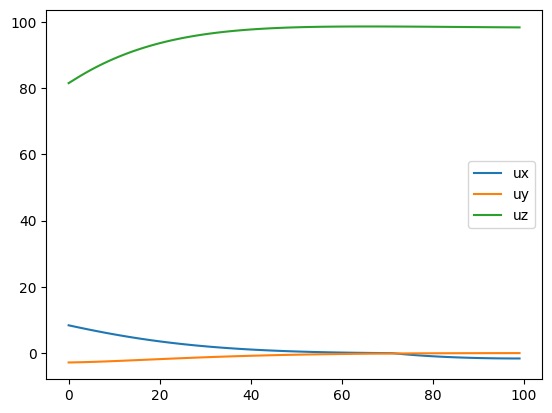

In [143]:
fig = plt.figure()
plot(Uhist[1, 1:NRUNS])
plot(Uhist[2, 1:NRUNS])
plot(Uhist[3, 1:NRUNS])
plt.legend(["ux", "uy", "uz"])
fig

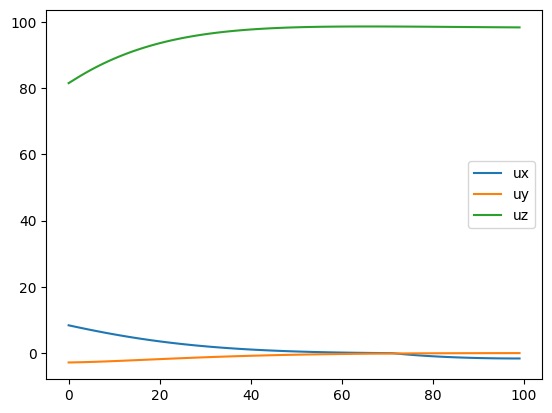

In [144]:
fig = plt.figure()
plot(Uhist[1, 1:NRUNS])
plot(Uhist[2, 1:NRUNS])
plot(Uhist[3, 1:NRUNS])
plt.legend(["ux", "uy", "uz"])
fig

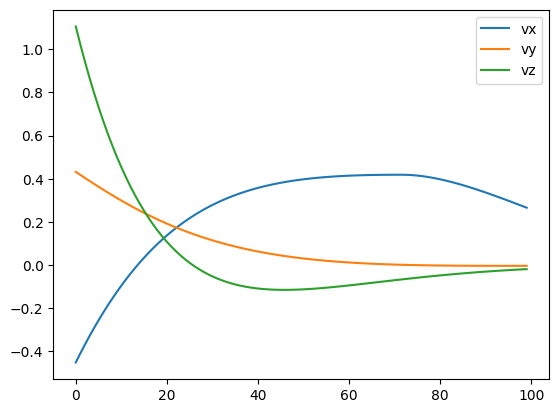

In [145]:
fig = plt.figure()
plot(Xhist[4,1:NRUNS])
plot(Xhist[5,1:NRUNS])
plot(Xhist[6,1:NRUNS])
plt.legend(["vx", "vy", "vz"])
# put limit on axis
# plt.ylim(-5, 20)
# plt.xlim(0, 300)
fig

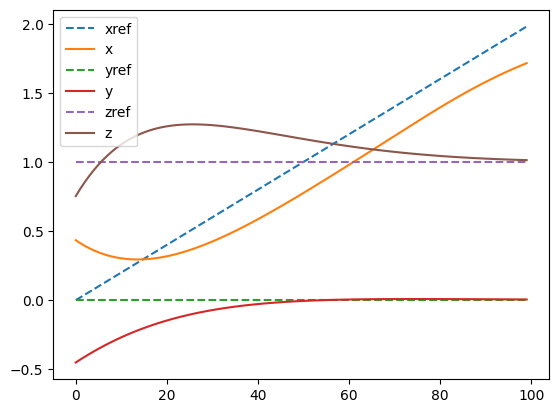

In [146]:
fig = plt.figure()
plot(Xref[1,1:NRUNS], "--")
plot(Xhist[1,1:NRUNS])
plot(Xref[2,1:NRUNS], "--") 
plot(Xhist[2,1:NRUNS])
plot(Xref[3,1:NRUNS], "--") 
plot(Xhist[3,1:NRUNS])
plt.legend(["xref", "x", "yref", "y", "zref", "z"])
# put limit on axis
# plt.ylim(-5, 20)
# plt.xlim(0, 300)
fig